# LSTM 계층 구현 

In [1]:
# 스타벅스 주가 데이터
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv(r'.\data/SBUX.csv')
print(data.dtypes)
print(data)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
           Date        Open        High         Low       Close   Adj Close  \
0    2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752   
1    2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032   
2    2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046   
3    2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941   
4    2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288   
..          ...         ...         ...         ...         ...         ...   
248  2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787   
249  2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918   
250  2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554   
251  2020-12-09  101.940002  102.209999  100.0999

In [2]:
import torch
import numpy as np
import random

def seed_everything(seed=4):
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)  # PyTorch 난수 고정
    torch.cuda.manual_seed(seed)  # CUDA 연산 시드 고정
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경 시드 고정
    torch.backends.cudnn.deterministic = True  # CUDA 연산 결정적으로 수행
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화

seed_everything(4)  # 시드 설정 실행

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [5]:
# 스케일러 적용
ms = MinMaxScaler() #0~1
ss = StandardScaler() # 평균 0, 표준편차 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


In [6]:
# 데이터셋 형태, 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


In [7]:
#네트워크 정의
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()

        #하이퍼 파라미터 
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        # LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        #Fully connected 레이어 정의
        self.fc_1 = nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x) :

        # hidden state & cell state 설정
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # LSTM 순전파 
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        #hidden state의 마지막 레이어 사용
        hn = hn.view(-1, self.hidden_size)
        
        # 활성화 함수 & FC layer 통과
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [8]:
# 변수값 설정
# 하이퍼 파라미터
num_epochs = 1000
lr = 0.0001

input_size=5
hidden_size=2
num_layers=1

# 모델 생성
num_classes=1 #출력값 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

# loss function 및 최적화 함수 정의

def mse_loss(outputs, y_train_tensors):
    return torch.sum((outputs - y_train_tensors)**2) / y_train_tensors.numel() #numel -> 전체 원소 개수
criterion = mse_loss 
#criterion = torch.nn.MSELoss() # MSE
#criterion = torch.nn.L1Loss() #MAE
#criterion = torch.nn.SmoothL1Loss() #Huber Loss
#criterion = torch.nn.HingeEmbeddingLoss() #분류에서 주로 사용
#criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam optimizer 사용

In [9]:
# 모델 학습
for epoch in range(num_epochs) :
#    outputs = model.forward(X_train_tensors_f) #그외
    outputs = model(X_train_tensors_f) # mse_loss 사용 경우 

    
    optimizer.zero_grad() # 이전 기울기 초기화
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step() #가중치 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.05219
Epoch : 100, loss : 0.03818
Epoch : 200, loss : 0.03527
Epoch : 300, loss : 0.03331
Epoch : 400, loss : 0.03225
Epoch : 500, loss : 0.03148
Epoch : 600, loss : 0.03059
Epoch : 700, loss : 0.02937
Epoch : 800, loss : 0.02797
Epoch : 900, loss : 0.02653


In [10]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

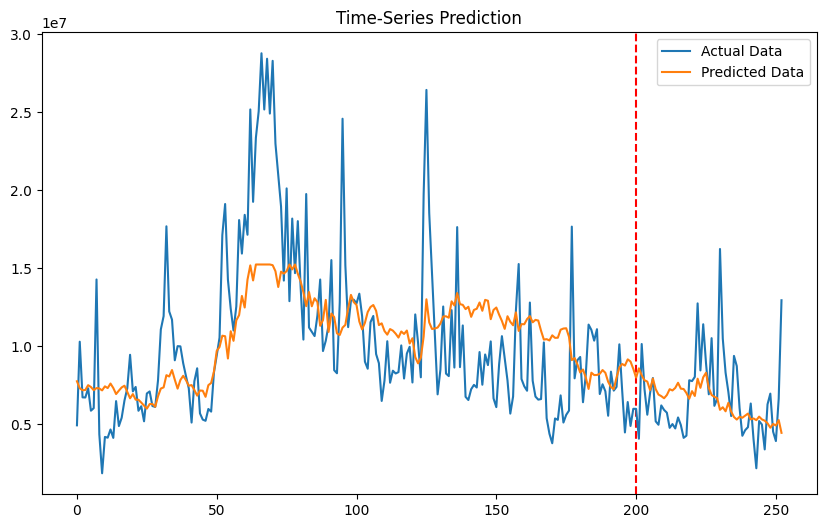

In [11]:
# 예측결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()